# Environment setup

In [2]:
# Load the packages
import os
import sys
import gc
import gseapy
import scanpy as sc
import decoupler as dc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')


# Set the system path
sys.path.append(os.path.abspath('../'))

from Utils.Preprocessing_scanpy import *


# Plotting options, change to your liking
sc.settings.set_figure_params(dpi=300, frameon=False)
sc.set_figure_params(dpi=300)
sc.set_figure_params(figsize=(4, 4))

# Load Data

In [3]:
ls ../data/Preprocessed_data/preprocessed_harmony_.h5ad

../data/Preprocessed_data/preprocessed_harmony_.h5ad


In [4]:
# Load example dataset
adata = sc.read('../data/Preprocessed_data/preprocessed_harmony_.h5ad')
adata

AnnData object with n_obs × n_vars = 7736 × 33694
    obs: 'batch', 'n_counts', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden'
    var: 'mean', 'std', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_pca_harmony', 'X_umap'
    varm: 'PCs'
    layers: 'log_norm', 'norm', 'raw', 'scale_data'
    obsp: 'connectivities', 'distances'

# Load marker gene database

Use cell type specific marker genes to annotate single cell clusters. Marker genes that are mainly expressed exclusively by a specific cell type, making them useful to distinguish heterogeneous groups of cells. Marker genes were discovered and annotated in previous studies and there are some resources that collect and curate them.

In [5]:
Marker_DB = 'CellMakers' # 'CellMakers' or 'CellMarkers'

In [6]:
if Marker_DB == 'PanglaoDB':
    # Query Omnipath and get PanglaoDB
    markers = dc.get_resource('PanglaoDB')

    # Human only (general)
    cell_markers = markers[(markers['organ']=='Immune system') & markers['canonical_marker'] & markers['human'] & (markers['human_sensitivity'] > 0.5)]

    # Remove duplicated entries
    cell_markers = cell_markers[~cell_markers.duplicated(['cell_type', 'genesymbol'])]

elif Marker_DB == 'CellMakers':
    # Load cell marker database
    markers = pd.read_csv('../data/CellMarker_DB/Cell_marker_Seq.csv')
    # Subset to human only. Can add more condition constraints here
    markers = markers[(markers['species']=='Human')]
    markers = markers.drop('Symbol', axis=1).rename(columns={'marker': 'genesymbol'})
    markers = markers.drop('cell_type', axis=1).rename(columns={'cell_name': 'cell_type'})
    is_d = markers.duplicated(['cell_type', 'genesymbol']).values
    cell_markers = markers[~is_d]

cell_markers.head(5)

,species,tissue_class,tissue_type,uberonongology_id,cancer_type,cell_type,cellontology_id,genesymbol,GeneID,Genetype,Genename,UNIPROTID,technology_seq,marker_source,PMID,Title,journal,year
0,Human,Abdomen,Abdominal fat pad,NaN,Normal,Brown adipocyte,CL_0000449,FABP4,2167.0,protein_coding,fatty acid binding protein 4,E7DVW4,sci-RNA-seq,Experiment,32355218.0,Single-cell transcriptional networks in differ...,Nature communications,2020.0
1,Human,Abdomen,Abdominal fat pad,NaN,Normal,Brown adipocyte,CL_0000449,PDGFRα,NaN,NaN,NaN,NaN,sci-RNA-seq,Experiment,32355218.0,Single-cell transcriptional networks in differ...,Nature communications,2020.0
2,Human,Abdomen,Abdominal fat pad,NaN,Normal,Brown adipocyte,CL_0000449,UCP1,7350.0,protein_coding,uncoupling protein 1,P25874,sci-RNA-seq,Experiment,32355218.0,Single-cell transcriptional networks in differ...,Nature communications,2020.0
22,Human,Adipose tissue,Adipose tissue,UBERON_0001013,Normal,Stem cell,CL_0000034,FABP4,2167.0,protein_coding,fatty acid binding protein 4,E7DVW4,Single-cell sequencing,Experiment,30639037.0,Patient adipose stem cell-derived adipocytes r...,Cell stem cell,2019.0
23,Human,Adipose tissue,Adipose tissue,UBERON_0001013,Normal,Pan fibroblast,NaN,vimentin,NaN,NaN,NaN,NaN,Single-cell sequencing,Experiment,31053654.0,Distinct immunocyte-promoting and adipocyte-ge...,Science immunology,2019.0


# Automatic annotation

## Enrichment with Over Representation Analysis

ORA (Over representation analysis): the top 5% of expressed genes by sample are selected as the set of interest (S)

In [7]:
dc.run_ora(
    mat=adata,
    net=cell_markers,
    source='cell_type',
    target='genesymbol',
    min_n=3,
    verbose=True,
    use_raw=False
)

12271 features of mat are empty, they will be removed.
Running ora on mat with 7736 samples and 21423 targets for 423 sources.


100%|██████████| 7736/7736 [00:29<00:00, 265.57it/s]


In [8]:
acts = dc.get_acts(adata, obsm_key='ora_estimate')

# We need to remove inf and set them to the maximum value observed for pvals=0
acts_v = acts.X.ravel()
max_e = np.nanmax(acts_v[np.isfinite(acts_v)])
acts.X[~np.isfinite(acts.X)] = max_e
acts

AnnData object with n_obs × n_vars = 7736 × 423
    obs: 'batch', 'n_counts', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden'
    uns: 'hvg', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_pca_harmony', 'X_umap', 'ora_estimate', 'ora_pvals'

In [9]:
df = dc.rank_sources_groups(acts, groupby='leiden', reference='rest', method='wilcoxon')
# df = dc.rank_sources_groups(acts, groupby='leiden', reference='rest', method='t-test')
df

,group,reference,names,statistic,meanchange,pvals,pvals_adj
0,0,rest,Stromal cell,21.493924,0.152861,1.774608e-102,7.506590e-101
1,0,rest,Fibrocartilage chondrocyte,21.371910,0.304252,2.439450e-101,9.380792e-100
2,0,rest,Mesangial cell,19.146711,0.201643,1.030962e-81,3.354593e-80
3,0,rest,m-Pericyte,17.267521,0.305688,8.261615e-67,2.329775e-65
4,0,rest,Microglial cell,16.113929,0.136742,2.036629e-58,4.786078e-57
...,...,...,...,...,...,...,...
3802,8,rest,CD8+ T cell,-2.765100,-0.012300,5.690529e-03,4.719792e-02
3803,8,rest,Normal cell,-2.950535,-0.142611,3.172239e-03,2.795536e-02
3804,8,rest,Secretory cell,-3.199686,-0.077282,1.375772e-03,1.492183e-02
3805,8,rest,Trophectoderm cell,-4.564008,-0.181831,5.018605e-06,1.010890e-04


In [10]:
n_ctypes = 5
ctypes_dict = df.groupby('group').head(n_ctypes).groupby('group')['names'].apply(lambda x: list(x)).to_dict()
ctypes_dict


{'0': ['Stromal cell',
  'Fibrocartilage chondrocyte',
  'Mesangial cell',
  'm-Pericyte',
  'Microglial cell'],
 '1': ['Interstitial progenitor cell',
  'Transit-amplifying cell',
  'Inner radial glial cell',
  'Proliferative cell',
  'Innate lymphoid cell'],
 '2': ['Plasma cell',
  'Macrophage',
  'Memory T cell',
  'Ductal cell',
  'Pelvic epithelial cell'],
 '3': ['Cartilage progenitor cell',
  'Nephron progenitor cell',
  'Interstitial progenitor cell',
  'Distal cell',
  'Transit-amplifying cell'],
 '4': ['CD4+ T cell',
  'Blood cell',
  'Hematopoietic cell',
  'Cancer-associated fibroblast',
  'M1 macrophage'],
 '5': ['Neural progenitor cell',
  'Loop progenitor cell',
  'Proliferative ductal cell',
  'Proliferative neural progenitor cell',
  'Exhausted T(Tex) cell'],
 '6': ['Cartilage progenitor cell',
  'Proliferative ductal cell',
  'Nephron progenitor cell',
  'Exhausted T(Tex) cell',
  'Cycling B cell'],
 '7': ['Regulatory chondrocyte',
  'Nephron progenitor cell',
  'Lymph

In [16]:
annotation_dict = df.groupby('group').head(1).set_index('group')['names'].to_dict()
print(annotation_dict)

# Add cell type column based on annotation
adata.obs['cell_type'] = [annotation_dict[clust] for clust in adata.obs['leiden']]
acts.obs['cell_type'] = [annotation_dict[clust] for clust in adata.obs['leiden']]

{'0': 'Stromal cell', '1': 'Interstitial progenitor cell', '2': 'Plasma cell', '3': 'Cartilage progenitor cell', '4': 'CD4+ T cell', '5': 'Neural progenitor cell', '6': 'Cartilage progenitor cell', '7': 'Regulatory chondrocyte', '8': 'Transit-amplifying cell'}


categories: CD4+ T cell, Cartilage progenitor cell, Interstitial progenitor cell, etc.
var_group_labels: 0, 1, 2, etc.


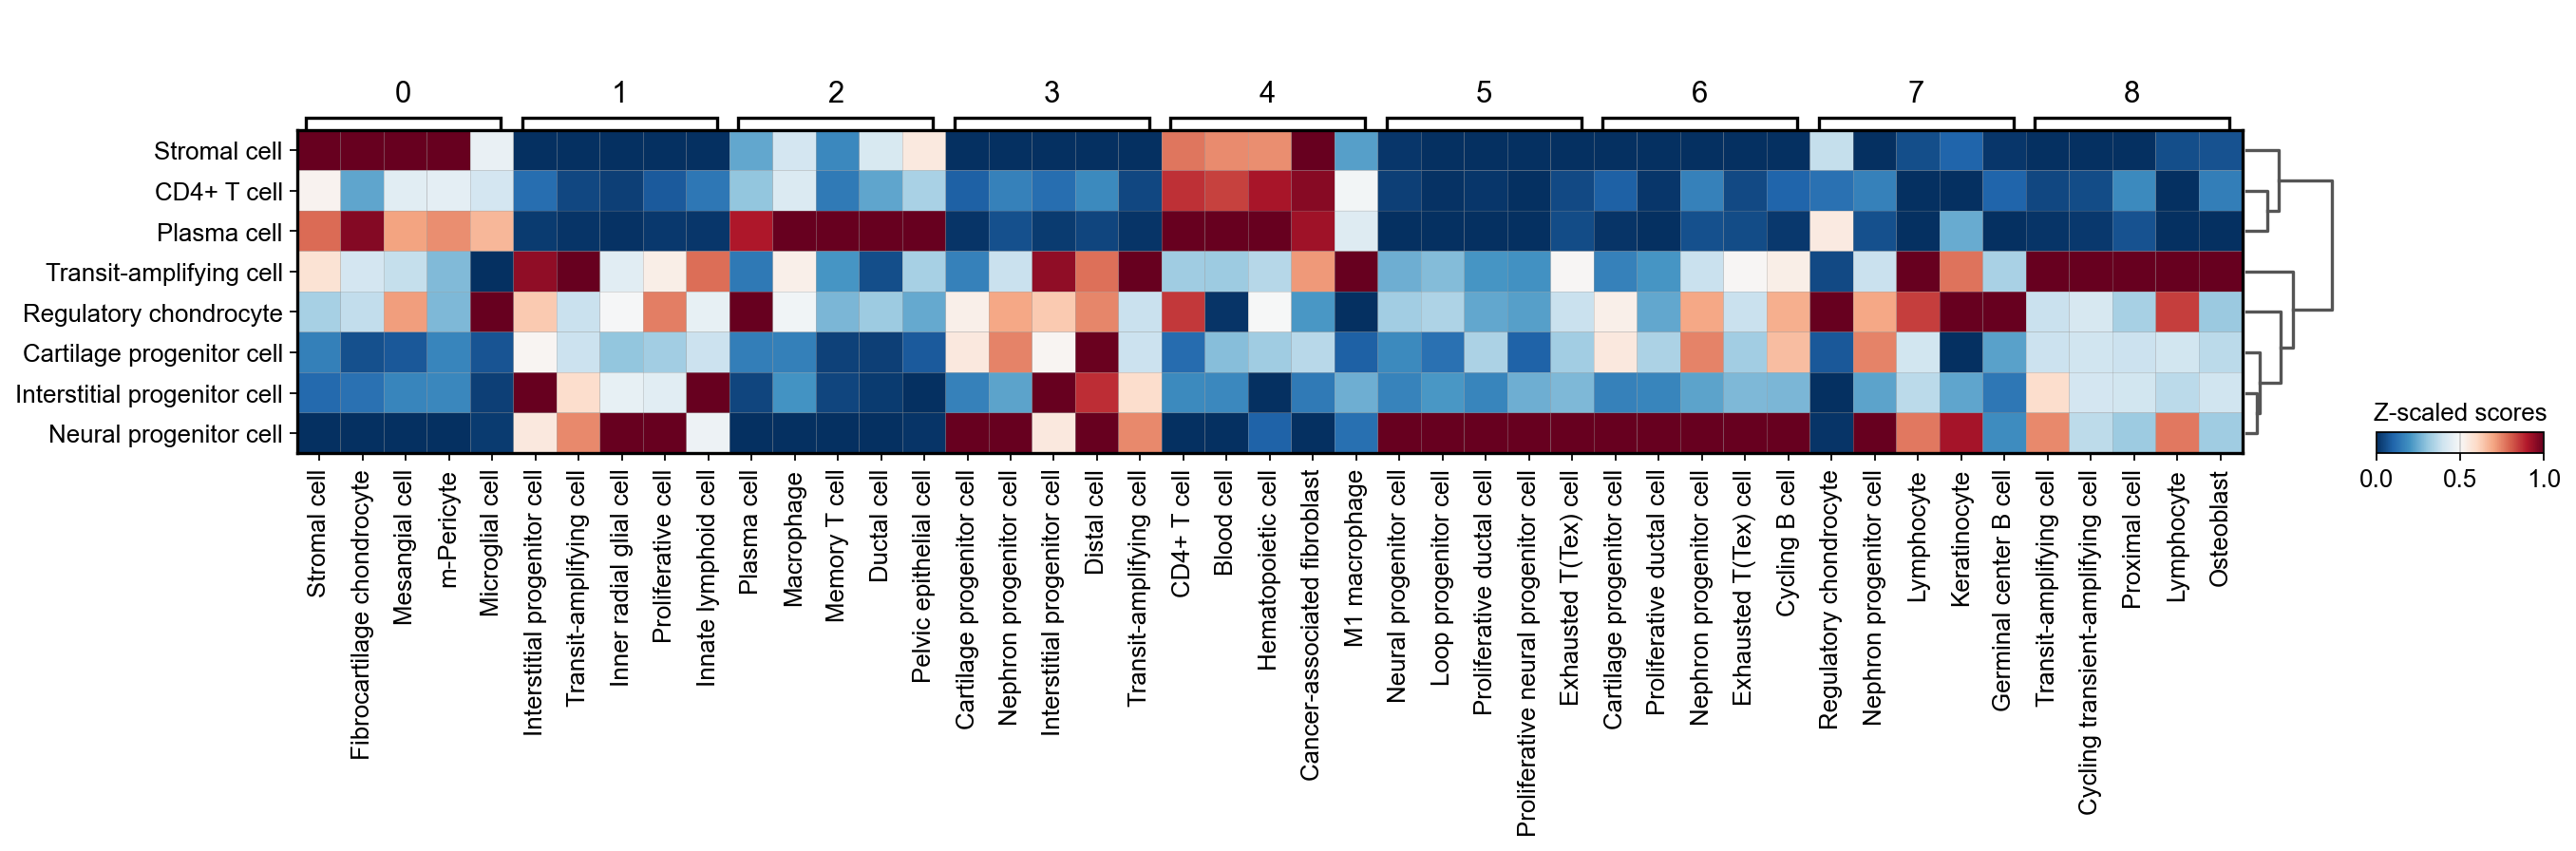

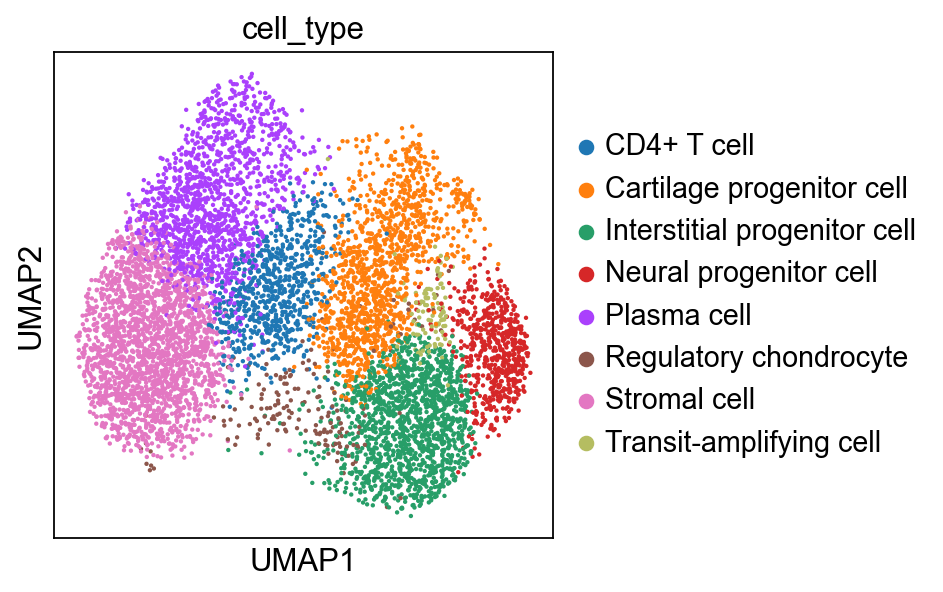

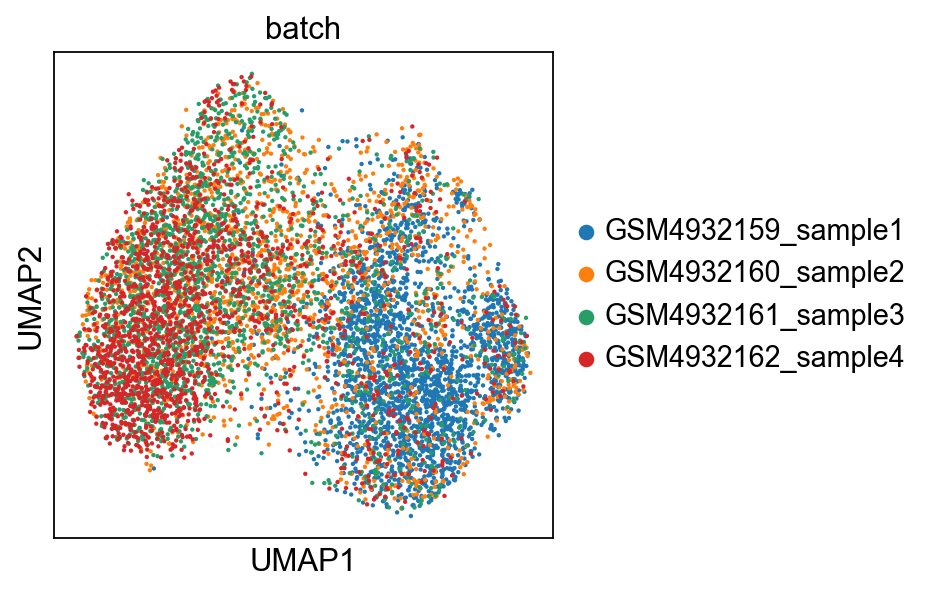

In [17]:
# Visualize
sc.pl.matrixplot(acts, ctypes_dict, 'cell_type', dendrogram=True, standard_scale='var',
                 colorbar_title='Z-scaled scores', cmap='RdBu_r')
sc.pl.umap(adata, color=['cell_type'])
sc.pl.umap(adata, color=['batch'])


In [18]:
adata.write('../data/Preprocessed_data/harmony_cellmarkers.h5ad')